<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Introduction" data-toc-modified-id="1-Introduction-1">1 Introduction</a></span></li><li><span><a href="#2-Data-access" data-toc-modified-id="2-Data-access-2">2 Data access</a></span></li><li><span><a href="#3-PCA-Analyses" data-toc-modified-id="3-PCA-Analyses-3">3 PCA Analyses</a></span><ul class="toc-item"><li><span><a href="#3.1-Feature-scaling" data-toc-modified-id="3.1-Feature-scaling-3.1">3.1 Feature scaling</a></span></li><li><span><a href="#3.2-Compute-PCA" data-toc-modified-id="3.2-Compute-PCA-3.2">3.2 Compute PCA</a></span></li><li><span><a href="#3.3-PCA-figure" data-toc-modified-id="3.3-PCA-figure-3.3">3.3 PCA figure</a></span></li></ul></li><li><span><a href="#4-Boxplot-Analysis" data-toc-modified-id="4-Boxplot-Analysis-4">4 Boxplot Analysis</a></span></li><li><span><a href="#5-Statistical-tests" data-toc-modified-id="5-Statistical-tests-5">5 Statistical tests</a></span><ul class="toc-item"><li><span><a href="#5.1-Shapiro-test" data-toc-modified-id="5.1-Shapiro-test-5.1">5.1 Shapiro test</a></span></li><li><span><a href="#5.2-Kurskal-test" data-toc-modified-id="5.2-Kurskal-test-5.2">5.2 Kurskal test</a></span></li><li><span><a href="#5.3-Mann-Whitney-U-test" data-toc-modified-id="5.3-Mann-Whitney-U-test-5.3">5.3 Mann-Whitney U test</a></span></li></ul></li></ul></div>

# 1 Introduction
<hr>
This notebook analyses the association of Optical Water Types (OWTs) with limnological parameters: Total Suspended Matter (TSM) concentration, Chlorophyll-a (Chl-a) concentration, Colored Dissolved Organic Matter (CDOM) absorption coefficient at 440 nm, and Secchi Depth (Zsd).

#### The analyses is performed using 3 methods:
1 - Principal component analysis (PCA).
<br>
The PCA analyses shows that each OWT is related with a limnological parameter (e.g. OWT and high Chl-a concentration).
<br>
<br>
2 - Boxplots
<br>
The boxplots are a graphical method for comparing the limnological concentration among all OWTs.
<br>
<br>
3 - Statistical tests
<br>
The tests were done for supporting that an OWT x have higher/lower limnological concentration than OWT Y.

# 2 Data access
<br>
Obs.: Notice that the raw dataset is not available because it is not an open source.

In [1]:
# library used
import psycopg2
import pandas as pd
import numpy as np

# access data
con = psycopg2.connect(host="localhost",
                       database="browts400_800",
                       user="postgres",
                       password="postgres123")

cluster = pd.read_sql_query('SELECT * FROM owt_named_2',
                            con,
                            index_col='ids')

si = pd.read_sql_query('SELECT * FROM si',
                       con,
                       index_col='ids')

si2 = pd.read_sql_query('SELECT * FROM si_int',
                        con,
                        index_col='ids')
lim = pd.read_sql_query('SELECT * FROM limnologia',
                        con,
                        index_col='id')

con.close()

# remove samples with silhouette  lower than 0
newid = si[si['OWTs'] != 'OWT 6'] # it is an exception due to a wrong measurement
newid = newid[newid['s']<0].dropna().index
cluster = cluster.drop(newid)
newid = si2[si2['OWTs'] != 'OWT 6'] # it is an exception due to wrong a measurement
newid = newid[newid['s']<0].dropna().index
cluster = cluster.drop(newid)

# concatenate lim with cluster
lim = cluster.join(lim.loc[:, ['clorofila_a_µg_l_',
                               'mstotal_mg_l',
                               'cdom_440_m_1',
                               'secchi_m']])

# remove known outliers
lim = lim.replace(0.0, np.nan) 
lim = lim.replace(-0.875000, np.nan)
lim = lim.drop('BNDES_Março2016_TAP7')
lim = lim.replace('Artifact', 'Artefact')

# remove artifact OWT and samples without all representative values
lim1 = lim[lim['OWTs'] != 'Artefact'].dropna()

A secondary dataset is created without OWT 5 and 8 because they represent extreme conditions with high Chl-a and TSM, respectively. Thus, the PCA analysis will be performed with and without those extreme conditions.

In [2]:
# create a dataset without  OWT 5 and 8
lim2 = lim1[lim1['OWTs'] != 'OWT 5']
lim2 = lim2[lim2['OWTs'] != 'OWT 8']

# 3 PCA Analyses

## 3.1 Feature scaling
<br>
Scaling is necessary for the PCA analysis because values of CDOM and Zsd are at a very lower scale than those of Chl-a and TSM. Here, the robust method is used because there is no normal distribution and there are many outliers needed for the analysis.

In [3]:
# library used
from sklearn.preprocessing import RobustScaler

# dataset 1 scaling
scaled_lim = lim1.iloc[:,1:].applymap(lambda x: x)
scaled_lim = RobustScaler().fit(scaled_lim).transform(scaled_lim)
scaled_lim = pd.DataFrame(scaled_lim,
                          index=lim1.index,
                          columns=lim1.columns[1:]).join(lim1.loc[:,'OWTs'])

# dataset 2 scaling
scaled_lim2 = lim2.iloc[:,1:].applymap(lambda x: x)
scaled_lim2 = RobustScaler().fit(scaled_lim2).transform(scaled_lim2)
scaled_lim2 = pd.DataFrame(scaled_lim2,
                           index=lim2.index,
                           columns=lim2.columns[1:]).join(lim2.loc[:,'OWTs'])

Scaling changes in the dataset 1


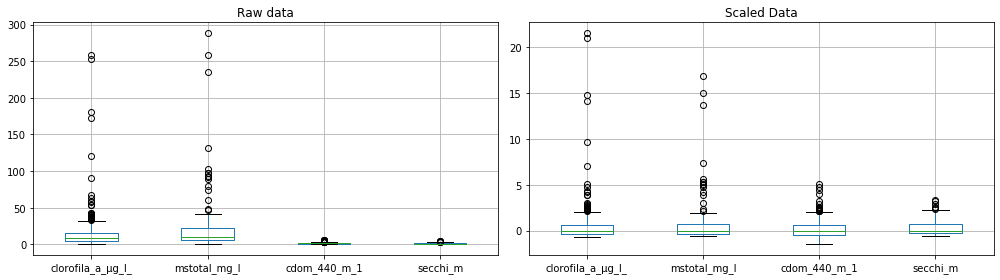

In [4]:
# scaling changes in the dataset 1
print('Scaling changes in the dataset 1')

# library used
import matplotlib.pyplot as plt

# plot
plt.figure(figsize=(14, 4))
i = 1
for x, y in zip([lim1, scaled_lim],
                ['Raw data', 'Scaled Data']):
    
    ax = plt.subplot(1, 2, i)
    g = x.boxplot(ax=ax)
    g.set_title(y)
    
    
    
    i = i + 1

plt.tight_layout()

Scaling changes in the dataset 2


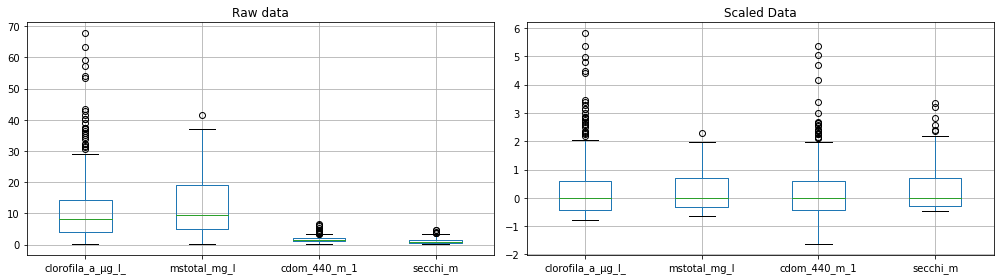

In [5]:
# scaling changes in the dataset 2
print('Scaling changes in the dataset 2')

# library used
import matplotlib.pyplot as plt

# plot
plt.figure(figsize=(14, 4))
i = 1
for x, y in zip([lim2, scaled_lim2],
                ['Raw data', 'Scaled Data']):
    
    ax = plt.subplot(1, 2, i)
    g = x.boxplot(ax=ax)
    g.set_title(y)
    
    
    
    i = i + 1

plt.tight_layout()

## 3.2 Compute PCA

In [6]:
# library used
from sklearn.decomposition import PCA

# dataset 1
# performs the PCA using standardized data
scaled_pc = PCA(n_components=2).fit(scaled_lim.loc[:, ['clorofila_a_µg_l_',
                                               'mstotal_mg_l',
                                               'cdom_440_m_1',
                                               'secchi_m']])

# saves the variance ratio of each PC
scaled_pc_vr = scaled_pc.explained_variance_ratio_

# saves the components
scaled_components = scaled_pc.components_

# transform the value to the PC dimension
scaled_pc = scaled_pc.transform(scaled_lim.loc[:, ['clorofila_a_µg_l_',
                                       'mstotal_mg_l',
                                       'cdom_440_m_1',
                                       'secchi_m']])

# saves the values in a pandas DataFrame
scaled_pc = pd.DataFrame(scaled_pc, columns=['PC 1', 'PC 2'])
scaled_pc.index = scaled_lim.index
scaled_pc = scaled_pc.join(scaled_lim.loc[:, 'OWTs'])


# dataset 2
# performs the PCA using standardized data
scaled_pc2 = PCA(n_components=2).fit(scaled_lim2.loc[:, ['clorofila_a_µg_l_',
                                                 'mstotal_mg_l',
                                                 'cdom_440_m_1',
                                                 'secchi_m']])

# compute the variance ratio of each PC
scaled_pc_vr2 = scaled_pc2.explained_variance_ratio_

# compute the components
scaled_components2 = scaled_pc2.components_

# transform the value to the PC dimension
scaled_pc2 = scaled_pc2.transform(scaled_lim2.loc[:, ['clorofila_a_µg_l_',
                                          'mstotal_mg_l',
                                          'cdom_440_m_1',
                                          'secchi_m']])

# saves the values in a pandas DataFrame
scaled_pc2 = pd.DataFrame(scaled_pc2, columns=['PC 1', 'PC 2'])
scaled_pc2.index = scaled_lim2.index
scaled_pc2 = scaled_pc2.join(scaled_lim2.loc[:, 'OWTs'])

## 3.3 PCA figure

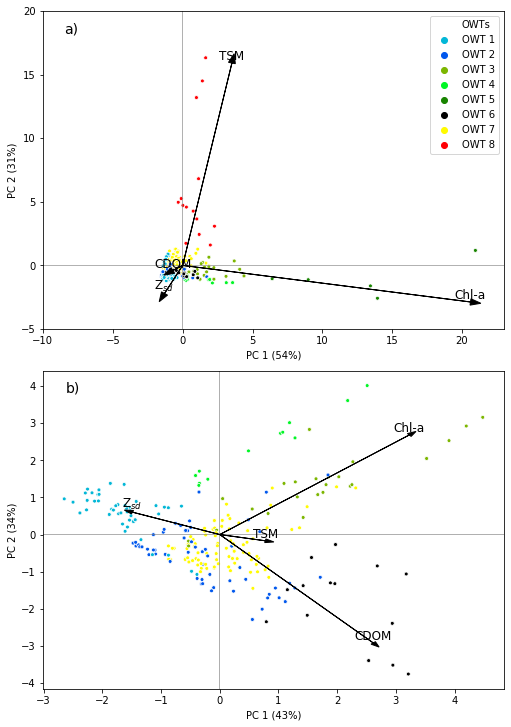

In [7]:
# dataset 1
# library used
import seaborn as sns

# compute figure size
fig = plt.figure(figsize=(7.2, 10.2))

# create subplot a
ax = plt.subplot(2, 1, 1)

# plot
g = sns.scatterplot(x='PC 1',
                  y='PC 2',
                  hue='OWTs',
                  hue_order=['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8'],
                  palette=['#02b7d7', '#0057ed', '#7cb600', '#00f625', '#188400', '#000000', '#fffb00', '#ff0004'],
                  data=scaled_pc,
                  s=15,
                  ax=ax)

# change axis limits and its labels
g.set_xlim(-10, 23)
g.set_ylim(-5, 20)
g.set_xlabel('PC 1 ('+str(scaled_pc_vr[0])[2:4]+'%)')
g.set_ylabel('PC 2 ('+str(scaled_pc_vr[1])[2:4]+'%)')

# add the subplot name
ax.text(-8, 18,
         'a)',
        fontsize=14,
       horizontalalignment='center',
       verticalalignment='bottom')

# draw the PC lines
ax.arrow(0,0,0,20,
        color='grey',
        linewidth=0.3)

ax.arrow(0,0,0,-20,
        color='grey',
        linewidth=0.3)

ax.arrow(0,0,30,0,
        color='grey',
        linewidth=0.3)

ax.arrow(0,0,-30,0,
        color='grey',
        linewidth=0.3)

# draw the parameters eigenvectors
for x, y in zip([0, 1, 2, 3],
               ['Chl-a', 'TSM', 'CDOM', 'Z$_{sd}$']):

    ax.arrow(0, 0,
              scaled_components[0][x]*max(scaled_pc['PC 1']),
              scaled_components[1][x]*max(scaled_pc['PC 2']),
              color='black',
              width=0.0005,
              head_width=0.5)
    
    ax.text(x=scaled_components[0][x]*max(scaled_pc['PC 1']),
         y=scaled_components[1][x]*max(scaled_pc['PC 2']),
         s=y,
         color='black',
        fontsize=12,
       horizontalalignment='center',
       verticalalignment='bottom');

#dataset 2
# create subplot b
ax2 = plt.subplot(2, 1, 2)

# plot
g = sns.scatterplot(x='PC 1',
                  y='PC 2',
                  hue='OWTs',
                  hue_order=['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 6', 'OWT 7'],
                  palette=['#02b7d7', '#0057ed', '#7cb600', '#00f625', '#000000', '#fffb00'],
                  data=scaled_pc2,
                  s=15,
                    legend=False,
                  ax=ax2)


# change axis labels
g.set_xlabel('PC 1 ('+str(scaled_pc_vr2[0])[2:4]+'%)')
g.set_ylabel('PC 2 ('+str(scaled_pc_vr2[1])[2:4]+'%)')

# add the subplot name
ax2.text(-2.5, 3.75,
         'b)',
        fontsize=14,
       horizontalalignment='center',
       verticalalignment='bottom')

# draw the pc lines
ax2.arrow(0,0,0,20,
        color='grey',
        linewidth=0.3)

ax2.arrow(0,0,0,-20,
        color='grey',
        linewidth=0.3)

ax2.arrow(0,0,30,0,
        color='grey',
        linewidth=0.3)

ax2.arrow(0,0,-30,0,
        color='grey',
        linewidth=0.3)

# draw the parameters eigenvectors
for x, y in zip([0, 1, 2, 3],
               ['Chl-a', 'TSM', 'CDOM', 'Z$_{sd}$']):

    ax2.arrow(0, 0,
              scaled_components2[0][x]*max(scaled_pc2['PC 1']),
              scaled_components2[1][x]*max(scaled_pc2['PC 2']),
              color='black',
              width=0.0005,
              head_width=0.1)
    
    ax2.text(x=scaled_components2[0][x]*max(scaled_pc2['PC 1']),
         y=scaled_components2[1][x]*max(scaled_pc2['PC 2']),
         s=y,
         color='black',
        fontsize=12,
       horizontalalignment='center',
       verticalalignment='bottom');
    
plt.tight_layout()

# 4 Boxplot Analysis

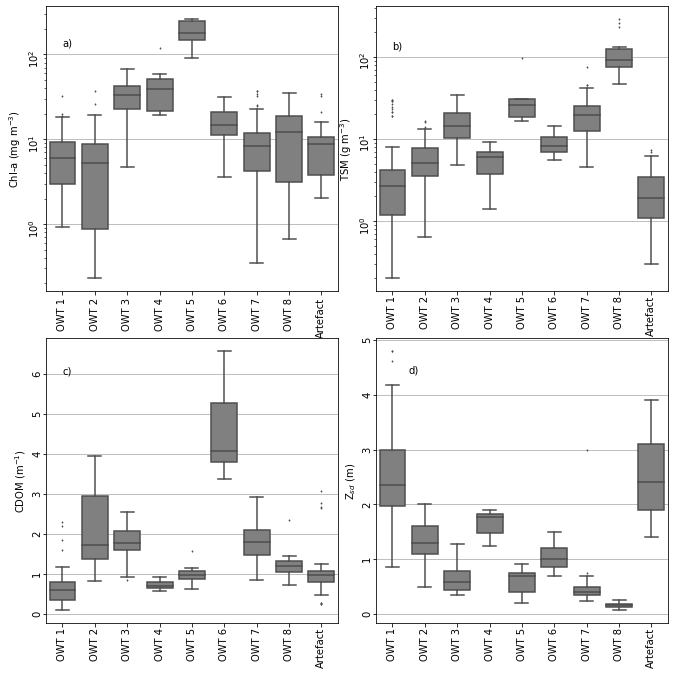

In [8]:
# order to plot along x axis in the boxplots
order = ['OWT 1',
         'OWT 2',
         'OWT 3',
         'OWT 4',
         'OWT 5',
         'OWT 6',
         'OWT 7',
         'OWT 8',
        'Artefact']

# create the figure and subplots
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(9.2, 9.2))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax4 = ax[1][0]
ax3 = ax[1][1]

# set the Chl-a and TSM subplots to log scale (due to the outliers)
ax1.set_yscale("log")
ax2.set_yscale("log")

# Chl-a subplot
sns.boxplot(x="OWTs",
            y="clorofila_a_µg_l_",
            data=lim,
            whis=1.5,
            showfliers=True,
            order=order,
            ax=ax1,
            fliersize=1,
            color='grey')

# change tick params
ax1.tick_params(axis='both',
                which='major',
                labelsize=10,
                pad=2,
                rotation=90)

# add grid lines
ax1.grid(axis='y')

# change y label
ax1.set_ylabel('Chl-a (mg m$^{-3}$)', fontsize=10)

# remove x label
ax1.set_xlabel('', fontsize=0)

# add subplot name
ax1.text(0, 125, 'a)', fontsize=10)

# set the gridlines backwards
ax1.set_axisbelow(True)

# TSM
sns.boxplot(x="OWTs",
            y="mstotal_mg_l",
            data=lim,
            fliersize=1,
           color='grey',
            whis=1.5,
            showfliers=True,
            order=order,
            ax=ax2)

# change tick params
ax2.tick_params(axis='both',
                which='major',
                labelsize=10,
                pad=0.6,
                rotation=90)

# add grid lines
ax2.grid(axis='y')

# change y label
ax2.set_ylabel('TSM (g m$^{-3}$)', fontsize=10)

# remove x label
ax2.set_xlabel('', fontsize=0)

# add subplot name
ax2.text(0, 125, 'b)', fontsize=10)

# set the gridlines backwards
ax2.set_axisbelow(True)

# Zsd
sns.boxplot(x="OWTs",
            y="secchi_m",
            data=lim,
            fliersize=1,
            color='grey',
            whis=1.5,
            showfliers=True,
            order=order,
            ax=ax3)

# change tick params
ax3.tick_params(axis='both',
                which='major',
                labelsize=10,
                pad=0.6,
                rotation=90)

# add grid lines
ax3.grid(axis='y')

# change y label
ax3.set_ylabel('Z$_{sd}$ (m)', fontsize=10)

# remove x label
ax3.set_xlabel('', fontsize=0)

# add subplot name
ax3.text(0.5, 4.4,'d)', fontsize=10)

# set the gridlines backwards
ax3.set_axisbelow(True)

# CDOM
sns.boxplot(x="OWTs",
            y="cdom_440_m_1",
            data=lim,
            fliersize=1,
            color='grey',
            whis=1.5,
            showfliers=True,
            order=order,
            ax=ax4)

# change tick params
ax4.tick_params(axis='both',
                which='major',
                labelsize=10,
                pad=0.6,
                rotation=90)

# add grid lines
ax4.grid(axis='y')

# change y label
ax4.set_ylabel('CDOM (m$^{-1}$)', fontsize=10)

# remove x label
ax4.set_xlabel('', fontsize=0)

# add subplot name
ax4.text(0, 6, 'c)', fontsize=10)

# set the gridlines backwards
ax4.set_axisbelow(True)

# remove or add spaces among subplots
plt.tight_layout(pad=0.1, h_pad=0.01)

# 5 Statistical tests

## 5.1 Shapiro test

In [9]:
# library used
from scipy.stats import shapiro

# dictionary for saving the output
shap_table = {}

for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8'] :
    
    subset = lim[lim.loc[:, 'OWTs'] == x]    
    shap_list = []
    
    for y in ['clorofila_a_µg_l_', 'mstotal_mg_l', 'cdom_440_m_1', 'secchi_m']:
        
        shap_res = np.round(shapiro(subset.loc[:,y].dropna())[1], 2)
        shap_list.append(shap_res)
        
    shap_table[x] = shap_list

print('Shapiro p-values')
pd.DataFrame(shap_table.values(),
             index=shap_table.keys(),
            columns = ['clorofila_a_µg_l_', 'mstotal_mg_l', 'cdom_440_m_1', 'secchi_m'])

Shapiro p-values


,clorofila_a_µg_l_,mstotal_mg_l,cdom_440_m_1,secchi_m
OWT 1,0.00,0.00,0.00,0.03
OWT 2,0.00,0.00,0.00,0.13
OWT 3,0.46,0.14,0.40,0.02
OWT 4,0.00,0.30,0.52,0.05
OWT 5,0.35,0.00,0.55,0.36
OWT 6,0.85,0.21,0.04,0.66
OWT 7,0.00,0.00,0.10,0.00
OWT 8,0.06,0.00,0.01,0.57


## 5.2 Kurskal test

In [10]:
# library used
from scipy.stats import kruskal

# dictionary for saving the results
kruskal_table = {}

for z in ['clorofila_a_µg_l_', 'mstotal_mg_l', 'cdom_440_m_1', 'secchi_m']:
    
    subset = lim.loc[:, ['OWTs', z]]
    owt_table = {}
    i = 1
    for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8']:
    
        subset2 = subset[subset.loc[:, 'OWTs'] == x].drop('OWTs', axis=1)
        owt_table[i] = subset2.dropna().values
        i = i + 1
    
    kruskal_res = kruskal(owt_table[1],
                         owt_table[2],
                         owt_table[3],
                         owt_table[4],
                         owt_table[5],
                         owt_table[6],
                         owt_table[7],
                         owt_table[8])[1]
    kruskal_table[z] = kruskal_res

print('Kruskal p-values')
pd.DataFrame(kruskal_table.values(),
            index=kruskal_table.keys(),
            columns=['Kruskal p-value'])

Kruskal p-values


,Kruskal p-value
clorofila_a_µg_l_,5.972417e-25
mstotal_mg_l,7.208428e-40
cdom_440_m_1,1.405944e-33
secchi_m,3.983034e-50


## 5.3 Mann-Whitney U test

In [11]:
# library used
from scipy.stats import mannwhitneyu
from IPython.core import display as ICD

# dictionary for saving results
utest_res = {}

for z in ['clorofila_a_µg_l_', 'mstotal_mg_l', 'cdom_440_m_1', 'secchi_m']:
    
    utest_table = {}
    for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8']:

        subset1 = lim[lim.loc[:, 'OWTs'] == x].loc[:, z].dropna().values        
        utest_list = []
        
        for y in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8']:

            subset2 = lim[lim.loc[:, 'OWTs'] == y].loc[:, z].dropna().values
            u_res = np.round(mannwhitneyu(subset1, subset2, alternative='two-sided')[1], 2)
            utest_list.append(u_res)
            
        utest_table[x] = utest_list
        
    utest_res[z] = pd.DataFrame(utest_table, index=utest_table.keys())

print('Mann-Whitney p-values \n')
for x in utest_res.keys():
    print(x)
    ICD.display(utest_res[x])
    print('\n')

Mann-Whitney p-values 

clorofila_a_µg_l_


,OWT 1,OWT 2,OWT 3,OWT 4,OWT 5,OWT 6,OWT 7,OWT 8
OWT 1,1.00,0.07,0.00,0.00,0.00,0.00,0.01,0.11
OWT 2,0.07,1.00,0.00,0.00,0.00,0.00,0.00,0.02
OWT 3,0.00,0.00,0.99,0.51,0.00,0.00,0.00,0.00
OWT 4,0.00,0.00,0.51,0.98,0.00,0.00,0.00,0.00
OWT 5,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00
OWT 6,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.28
OWT 7,0.01,0.00,0.00,0.00,0.00,0.00,1.00,0.48
OWT 8,0.11,0.02,0.00,0.00,0.00,0.28,0.48,0.98




mstotal_mg_l


,OWT 1,OWT 2,OWT 3,OWT 4,OWT 5,OWT 6,OWT 7,OWT 8
OWT 1,1.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
OWT 2,0.00,1.00,0.00,0.57,0.00,0.00,0.00,0.00
OWT 3,0.00,0.00,0.99,0.00,0.01,0.00,0.02,0.00
OWT 4,0.01,0.57,0.00,0.98,0.00,0.00,0.00,0.00
OWT 5,0.00,0.00,0.01,0.00,0.95,0.00,0.11,0.00
OWT 6,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00
OWT 7,0.00,0.00,0.02,0.00,0.11,0.00,1.00,0.00
OWT 8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98




cdom_440_m_1


,OWT 1,OWT 2,OWT 3,OWT 4,OWT 5,OWT 6,OWT 7,OWT 8
OWT 1,1.00,0.00,0.00,0.09,0.01,0.00,0.00,0.00
OWT 2,0.00,1.00,0.58,0.00,0.00,0.00,0.70,0.00
OWT 3,0.00,0.58,0.99,0.00,0.00,0.00,0.78,0.00
OWT 4,0.09,0.00,0.00,0.98,0.01,0.00,0.00,0.00
OWT 5,0.01,0.00,0.00,0.01,0.95,0.00,0.00,0.13
OWT 6,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00
OWT 7,0.00,0.70,0.78,0.00,0.00,0.00,1.00,0.00
OWT 8,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.98




secchi_m


,OWT 1,OWT 2,OWT 3,OWT 4,OWT 5,OWT 6,OWT 7,OWT 8
OWT 1,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
OWT 2,0.0,1.00,0.00,0.00,0.00,0.01,0.00,0.00
OWT 3,0.0,0.00,0.99,0.00,0.91,0.00,0.00,0.00
OWT 4,0.0,0.00,0.00,0.98,0.00,0.00,0.00,0.00
OWT 5,0.0,0.00,0.91,0.00,0.94,0.01,0.13,0.00
OWT 6,0.0,0.01,0.00,0.00,0.01,0.98,0.00,0.00
OWT 7,0.0,0.00,0.00,0.00,0.13,0.00,1.00,0.00
OWT 8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.98
